In [21]:
import os
#go back one directory
os.chdir("..")

In [22]:
sat_list = {
    'TerraSAR-X': {
        'norad_id': 31698,
        'sp3-c_code':"L13",
        'mass': 1230.0,          
        'cross_section': 4,  
        'cd': 2.2,             
        'cr': 1.5
    },
    'GRACE-FO -A': {
        'norad_id': 43476,
        'sp3-c_code':"L64",
        'mass': 600.2,          
        'cross_section': 3.123,
        'cd': 2.2,             
        'cr': 1.5  
    },
    'GRACE-FO -B': {
        'norad_id': 43477,
        'sp3-c_code':"L65",
        'mass': 600.2,          
        'cross_section': 3.123,
        'cd': 2.2,             
        'cr': 1.5  
    },
    'TanDEM-X': {
    'norad_id': 36605,
    'sp3-c_code':"L20",
    'mass': 1350.0,          
    'cross_section': 5,  
    'cd': 2.2,             
    'cr': 1.5
    },
}

In [43]:
import pandas as pd
import sp3
import gzip
import tempfile
import os

def read_sp3_gz_file(sp3_gz_file_path):
    # Create a temporary file to store the uncompressed data
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.sp3')
    temp_file_path = temp_file.name

    # Uncompress the .sp3.gz file and write to the temporary file
    with gzip.open(sp3_gz_file_path, 'rb') as gz_file:
        temp_file.write(gz_file.read())
    temp_file.close()

    # Load SP3 file
    product = sp3.Product.from_file(temp_file_path)

    # Assuming to use the first satellite in the file
    satellite = product.satellites[0]

    # Extracting records
    records = satellite.records

    # Preparing lists to store data
    times = []
    positions = []
    velocities = []

    # Loop through each record and extract data
    for record in records:
        times.append(record.time)
        positions.append(record.position)
        velocities.append(record.velocity if record.velocity else (None, None, None))

    # Creating a DataFrame
    df = pd.DataFrame({
        'Time': times,
        'Position_X': [pos[0] for pos in positions],
        'Position_Y': [pos[1] for pos in positions],
        'Position_Z': [pos[2] for pos in positions],
        'Velocity_X': [vel[0] for vel in velocities],
        'Velocity_Y': [vel[1] for vel in velocities],
        'Velocity_Z': [vel[2] for vel in velocities]
    })

    # Clean up temporary file
    os.remove(temp_file_path)

    return df

# Example usage
sp3_gz_file_path = 'notebooks/sp3_cache/GFZOP_RSO_L65_G_20230504_220000_20230505_120000_v02.sp3.gz'
df = read_sp3_gz_file(sp3_gz_file_path)
print(df.head())

                       Time   Position_X  Position_Y   Position_Z  \
0 2023-05-04 21:59:42+00:00  2259132.749 -589527.477 -6459887.886   
1 2023-05-04 22:00:12+00:00  2052366.384 -528156.872 -6534063.516   
2 2023-05-04 22:00:42+00:00  1843621.454 -465298.116 -6601023.225   
3 2023-05-04 22:01:12+00:00  1633133.746 -401012.117 -6660694.886   
4 2023-05-04 22:01:42+00:00  1421140.554 -335362.345 -6713014.377   

    Velocity_X   Velocity_Y   Velocity_Z  
0 -6856.630545  2020.229352 -2591.918762  
1 -6926.493544  2070.820487 -2352.678467  
2 -6988.525047  2119.424796 -2110.901374  
3 -7042.670363  2165.955812 -1866.853102  
4 -7088.883856  2210.329179 -1620.801518  


In [44]:
import pandas as pd
import sp3
import gzip
import tempfile
import os
import glob

sat_list = {
    'TerraSAR-X': {'sp3-c_code':"L13"},
    'GRACE-FO -A': {'sp3-c_code':"L64"},
    'GRACE-FO -B': {'sp3-c_code':"L65"},
    'TanDEM-X': {'sp3-c_code':"L20"}
}

def read_sp3_gz_file(sp3_gz_file_path):
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.sp3')
    temp_file_path = temp_file.name

    with gzip.open(sp3_gz_file_path, 'rb') as gz_file:
        temp_file.write(gz_file.read())
    temp_file.close()

    product = sp3.Product.from_file(temp_file_path)
    satellite = product.satellites[0]
    records = satellite.records

    times = []
    positions = []
    velocities = []

    for record in records:
        times.append(record.time)
        positions.append(record.position)
        velocities.append(record.velocity if record.velocity else (None, None, None))

    df = pd.DataFrame({
        'Time': times,
        'Position_X': [pos[0] for pos in positions],
        'Position_Y': [pos[1] for pos in positions],
        'Position_Z': [pos[2] for pos in positions],
        'Velocity_X': [vel[0] for vel in velocities],
        'Velocity_Y': [vel[1] for vel in velocities],
        'Velocity_Z': [vel[2] for vel in velocities]
    })

    os.remove(temp_file_path)
    return df

def process_sp3_files(base_path, sat_list):
    all_dataframes = {}

    for sat_name, sat_info in sat_list.items():
        sp3_c_code = sat_info['sp3-c_code']
        satellite_path = os.path.join(base_path, sp3_c_code)
        for day_folder in glob.glob(f"{satellite_path}/*"):
            for sp3_gz_file in glob.glob(f"{day_folder}/*.sp3.gz"):
                df = read_sp3_gz_file(sp3_gz_file)
                all_dataframes[(sat_name, os.path.basename(sp3_gz_file))] = df

    return all_dataframes

# Specify the base path to your sp3_cache folder
base_path = 'notebooks/sp3_cache'
dataframes = process_sp3_files(base_path, sat_list)

# Example of accessing a specific dataframe
sat_name = 'GRACE-FO-B'
sp3_file = 'GFZOP_RSO_L65_G_20230504_220000_20230505_120000_v02.sp3.gz'
print(dataframes[(sat_name, sp3_file)].head())


                       Time   Position_X  Position_Y   Position_Z  \
0 2023-05-04 21:59:42+00:00  2259132.749 -589527.477 -6459887.886   
1 2023-05-04 22:00:12+00:00  2052366.384 -528156.872 -6534063.516   
2 2023-05-04 22:00:42+00:00  1843621.454 -465298.116 -6601023.225   
3 2023-05-04 22:01:12+00:00  1633133.746 -401012.117 -6660694.886   
4 2023-05-04 22:01:42+00:00  1421140.554 -335362.345 -6713014.377   

    Velocity_X   Velocity_Y   Velocity_Z  
0 -6856.630545  2020.229352 -2591.918762  
1 -6926.493544  2070.820487 -2352.678467  
2 -6988.525047  2119.424796 -2110.901374  
3 -7042.670363  2165.955812 -1866.853102  
4 -7088.883856  2210.329179 -1620.801518  


In [45]:
# Example of accessing a specific dataframe
sat_name = 'GRACE-FO-B'
sp3_file = 'GFZOP_RSO_L65_G_20230504_220000_20230505_120000_v02.sp3.gz'
print(dataframes[(sat_name, sp3_file)].tail())

                          Time   Position_X   Position_Y   Position_Z  \
1677 2023-05-05 11:58:12+00:00 -4170661.582  4501985.803 -3072900.241   
1678 2023-05-05 11:58:42+00:00 -4092542.507  4430454.729 -3275728.037   
1679 2023-05-05 11:59:12+00:00 -4010228.187  4353679.623 -3474912.098   
1680 2023-05-05 11:59:42+00:00 -3923833.688  4271728.650 -3670232.070   
1681 2023-05-05 12:00:12+00:00 -3833478.244  4184676.188 -3861472.059   

       Velocity_X   Velocity_Y   Velocity_Z  
1677  2532.805783 -2296.263478 -6819.171458  
1678  2674.517316 -2472.130977 -6701.433813  
1679  2812.464675 -2645.830676 -6576.279283  
1680  2946.506097 -2817.154269 -6443.852603  
1681  3076.505391 -2985.895849 -6304.306661  


In [46]:
# Example of accessing a specific dataframe
sat_name = 'GRACE-FO-B'
sp3_file = 'GFZOP_RSO_L65_G_20230505_100000_20230506_000000_v02.sp3.gz'
print(dataframes[(sat_name, sp3_file)].head())

                       Time   Position_X   Position_Y   Position_Z  \
0 2023-05-05 09:59:42+00:00 -2681103.620   985182.710  6234127.618   
1 2023-05-05 10:00:12+00:00 -2875566.836  1053491.510  6135403.206   
2 2023-05-05 10:00:42+00:00 -3066560.096  1121481.545  6029862.871   
3 2023-05-05 10:01:12+00:00 -3253873.540  1189061.905  5917622.326   
4 2023-05-05 10:01:42+00:00 -3437301.662  1256141.185  5798804.778   

    Velocity_X   Velocity_Y   Velocity_Z  
0 -6537.573293  2281.267520 -3175.992440  
1 -6425.452199  2272.150744 -3405.034315  
2 -6306.265798  2260.013153 -3630.345133  
3 -6180.155310  2244.836301 -3851.673275  
4 -6047.269766  2226.605749 -4068.771206  


In [89]:
import pandas as pd
import sp3
import gzip
import tempfile
import os
import glob

sat_list = {
    'TerraSAR-X': {'sp3-c_code':"L13"},
    'GRACE-FO-A': {'sp3-c_code':"L64"},
    'GRACE-FO-B': {'sp3-c_code':"L65"},
    'TanDEM-X': {'sp3-c_code':"L20"}
}

def read_sp3_gz_file(sp3_gz_file_path):
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.sp3')
    temp_file_path = temp_file.name

    with gzip.open(sp3_gz_file_path, 'rb') as gz_file:
        temp_file.write(gz_file.read())
    temp_file.close()

    product = sp3.Product.from_file(temp_file_path)
    satellite = product.satellites[0]
    records = satellite.records

    times = []
    positions = []
    velocities = []

    for record in records:
        times.append(record.time)
        positions.append(record.position)
        velocities.append(record.velocity if record.velocity else (None, None, None))

    df = pd.DataFrame({
        'Time': times,
        'Position_X': [pos[0]/1000 for pos in positions],
        'Position_Y': [pos[1]/1000 for pos in positions],
        'Position_Z': [pos[2]/1000 for pos in positions],
        'Velocity_X': [vel[0]/1000 for vel in velocities],
        'Velocity_Y': [vel[1]/1000 for vel in velocities],
        'Velocity_Z': [vel[2]/1000 for vel in velocities]
    })

    os.remove(temp_file_path)
    return df

def process_sp3_files(base_path, sat_list):
    all_dataframes = {sat_name: [] for sat_name in sat_list}

    for sat_name, sat_info in sat_list.items():
        sp3_c_code = sat_info['sp3-c_code']
        satellite_path = os.path.join(base_path, sp3_c_code)
        for day_folder in glob.glob(f"{satellite_path}/*"):
            for sp3_gz_file in glob.glob(f"{day_folder}/*.sp3.gz"):
                df = read_sp3_gz_file(sp3_gz_file)
                all_dataframes[sat_name].append(df)

    # Concatenating dataframes for each spacecraft
    concatenated_dataframes = {}
    for sat_name, dfs in all_dataframes.items():
        concatenated_df = pd.concat(dfs).drop_duplicates(subset='Time').set_index('Time').sort_index()
        
        # Checking for consistent time intervals (30 seconds), ignoring NaN values
        time_diffs = concatenated_df.index.to_series().diff().dt.total_seconds()
        if not time_diffs[time_diffs.notna()].eq(30).all():
            print(f"found a time interval of {time_diffs[time_diffs.notna()].unique()} seconds in data for {sat_name}")
            raise ValueError(f"Inconsistent time intervals found in data for {sat_name}")

        concatenated_dataframes[sat_name] = concatenated_df

    return concatenated_dataframes

# Specify the base path to your sp3_cache folder
base_path = 'notebooks/sp3_cache'
concatenated_dfs = process_sp3_files(base_path, sat_list)


In [102]:
import pandas as pd
import numpy as np
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, ITRS, ICRS, GCRS, TEME
from astropy.time import Time
from astropy import units as u
import datetime

import datetime

def utc_jd_date(year, month, day, hours, minutes, seconds, mjd=False):
    try:
        date = datetime.datetime(year, month, day, hours, minutes, seconds)
    except ValueError as e:
        print(f"Error in date conversion: {e}")
        return None

    mjd_val = (date - datetime.datetime(1858, 11, 17)).total_seconds() / 86400.0
    return mjd_val if mjd else mjd_val + 2400000.5

from astropy.coordinates import GCRS, ITRS, CartesianRepresentation, CartesianDifferential
from astropy import units as u
import numpy as np

def itrs_to_gcrs(itrs_pos, itrs_vel, mjd):
    # Create a Time object from the Modified Julian Date
    time_utc = Time(mjd, format="mjd", scale='utc')

    # Create ITRS coordinates with position and velocity
    itrs_cartesian = CartesianRepresentation(itrs_pos.T * u.km)
    itrs_velocity = CartesianDifferential(itrs_vel.T * u.km / u.s)
    itrs_coords = ITRS(itrs_cartesian.with_differentials(itrs_velocity), obstime=time_utc)

    # Transform ITRS coordinates to GCRS
    gcrs_coords = itrs_coords.transform_to(GCRS(obstime=time_utc))

    # Extract the position and velocity from GCRS coordinates
    gcrs_pos = np.column_stack((gcrs_coords.cartesian.x.value, 
                                gcrs_coords.cartesian.y.value, 
                                gcrs_coords.cartesian.z.value))
    gcrs_vel = np.column_stack((gcrs_coords.cartesian.differentials['s'].d_x.value, 
                                gcrs_coords.cartesian.differentials['s'].d_y.value, 
                                gcrs_coords.cartesian.differentials['s'].d_z.value))

    return gcrs_pos, gcrs_vel


# Assuming 'concatenated_dfs' is your dictionary of DataFrames
for satellite, df in concatenated_dfs.items():
    # Convert the index to datetime if it's not already
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
        print

    # Convert time to MJD
    mjd_times = [utc_jd_date(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, mjd=True) for dt in df.index]
    df['MJD'] = mjd_times

    # Prepare ITRS coordinates
    itrs_positions = df[['Position_X', 'Position_Y', 'Position_Z']].values
    itrs_velocities = df[['Velocity_X', 'Velocity_Y', 'Velocity_Z']].values

    # Convert to ICRS (ECI)
    icrs_positions, icrs_velocities = itrs_to_gcrs(itrs_positions, itrs_velocities, df['MJD'].iloc[0])

    # Add new columns for ECI coordinates
    df['pos_x_eci'], df['pos_y_eci'], df['pos_z_eci'] = icrs_positions.T
    df['vel_x_eci'], df['vel_y_eci'], df['vel_z_eci'] = icrs_velocities.T


In [103]:
df

,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,MJD,pos_x_eci,pos_y_eci,pos_z_eci,vel_x_eci,vel_y_eci,vel_z_eci
Time,,,,,,,,,,,,,
2023-05-04 21:59:42+00:00,394.272716,1083.279372,-6798.235729,3.995799,-6.482251,-0.801731,60068.916458,-172.618636,-1142.209550,-6797.831592,-5.189624,5.484082,-0.790229
2023-05-04 22:00:12+00:00,513.484924,887.998851,-6818.573691,3.950925,-6.535241,-0.554012,60068.916806,-330.321528,-976.408687,-6817.820009,-5.168447,5.533843,-0.542559
2023-05-04 22:00:42+00:00,631.283252,691.237778,-6831.470500,3.901555,-6.580943,-0.305699,60068.917153,-486.937258,-808.862542,-6830.369748,-5.141466,5.577504,-0.294307
2023-05-04 22:01:12+00:00,747.534087,493.215851,-6836.912327,3.847773,-6.619288,-0.057058,60068.917500,-642.288920,-639.757755,-6835.467373,-5.108737,5.614993,-0.045740
2023-05-04 22:01:42+00:00,862.106454,294.154686,-6834.893358,3.789672,-6.650216,0.191643,60068.917847,-796.201798,-469.283394,-6833.107457,-5.070323,5.646245,0.202875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-20 23:58:12+00:00,643.999966,-5327.842750,-4327.500900,-1.079763,-4.865030,5.835553,60084.998750,-1761.106069,5072.673463,-4323.701853,-0.325615,4.855773,5.836158
2023-05-20 23:58:42+00:00,610.947549,-5470.795416,-4150.093909,-1.123386,-4.664242,5.990506,60084.999097,-1758.495817,5219.385957,-4146.304564,-0.251043,4.668837,5.990949
2023-05-20 23:59:12+00:00,576.617894,-5607.644085,-3968.135827,-1.164901,-4.458135,6.138931,60084.999444,-1753.341490,5360.400364,-3964.361724,-0.177010,4.476442,6.139214


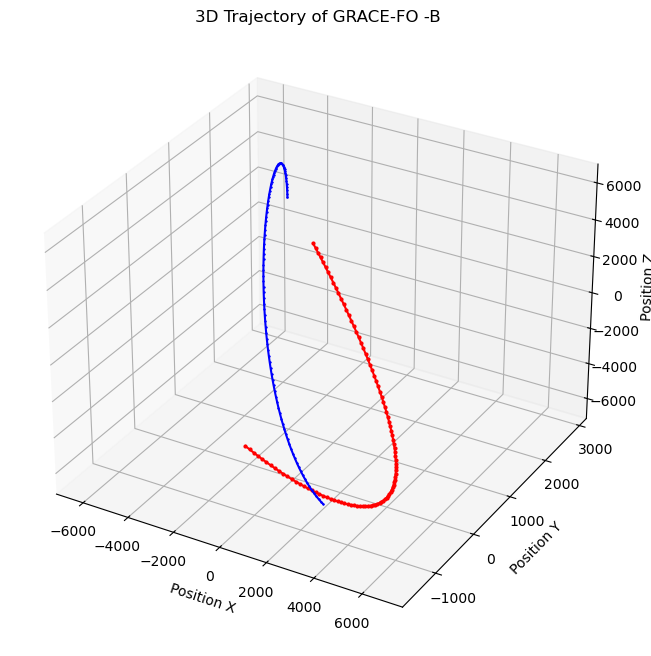

In [106]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'concatenated_dfs' contains the concatenated DataFrame for 'GRACE-FO -B'
grace_fo_b_df = concatenated_dfs['GRACE-FO-B']

# Extracting the X, Y, Z coordinates
x = grace_fo_b_df['pos_x_eci'].iloc[:100]
y = grace_fo_b_df['pos_y_eci'].iloc[:100]
z = grace_fo_b_df['pos_z_eci'].iloc[:100]

x2 = grace_fo_b_df['Position_X'].iloc[:100]
y2 = grace_fo_b_df['Position_Y'].iloc[:100]
z2 = grace_fo_b_df['Position_Z'].iloc[:100]

# Creating a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the X, Y, Z coordinates
ax.plot(x, y, z, marker='o', linestyle='-', markersize=2, color='red')
ax.plot(x2, y2, z2, marker='+', linestyle='-', markersize=2, color='blue')

ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_zlabel('Position Z')
ax.set_title('3D Trajectory of GRACE-FO -B')

plt.show()

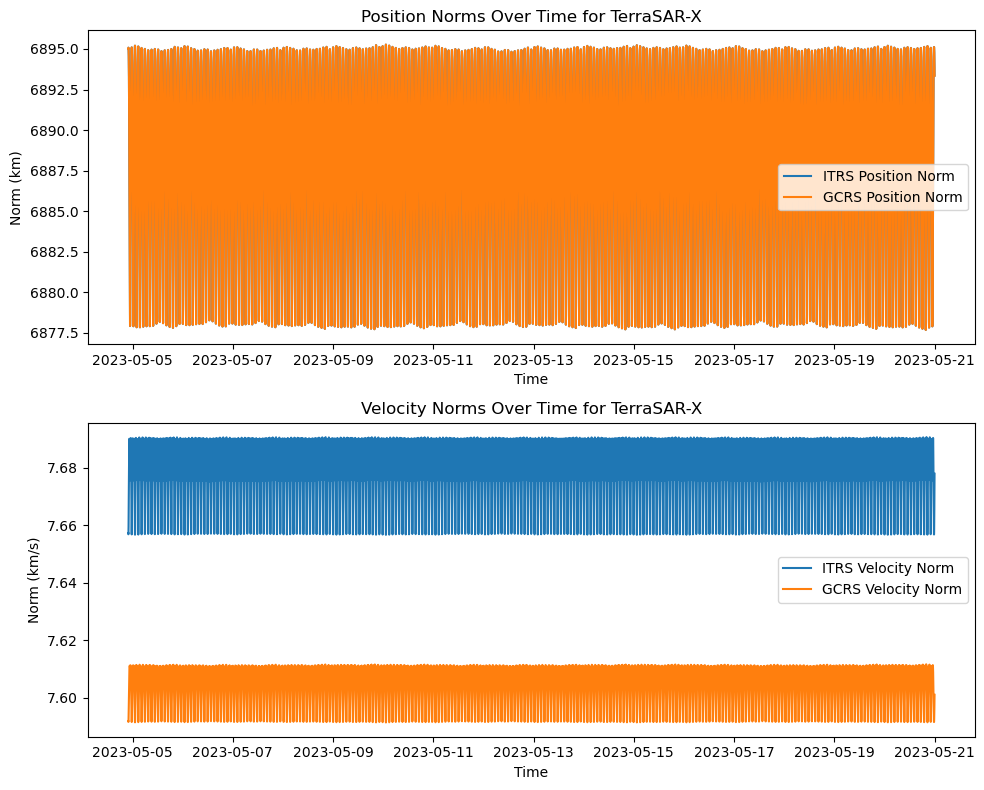

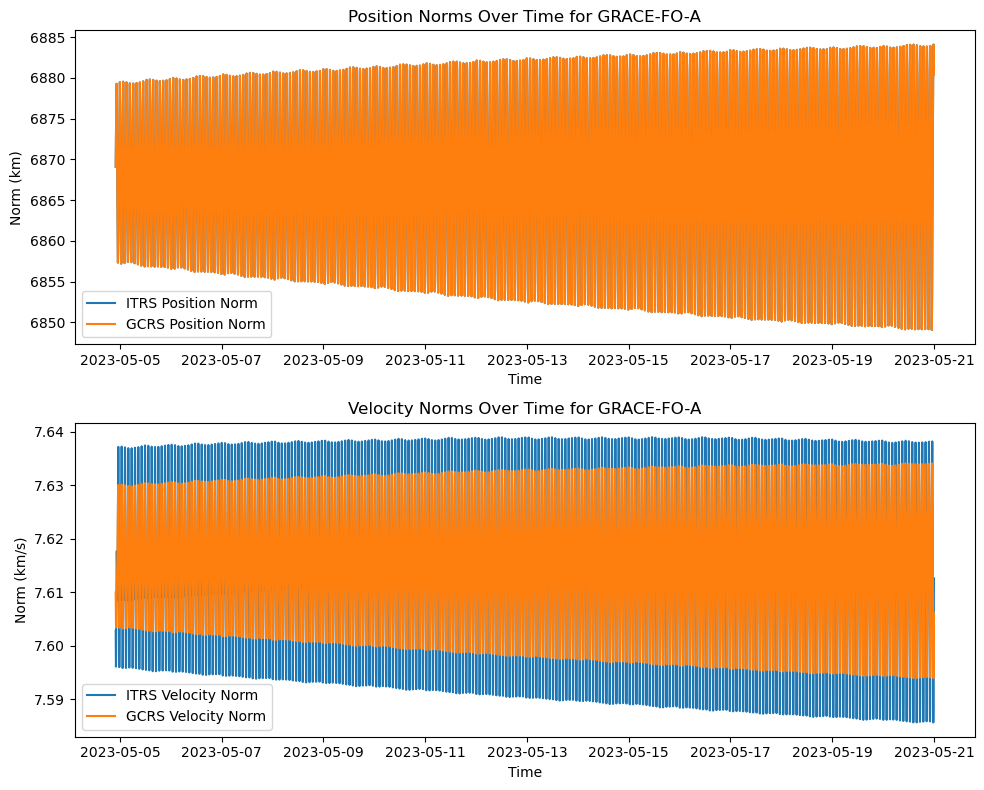

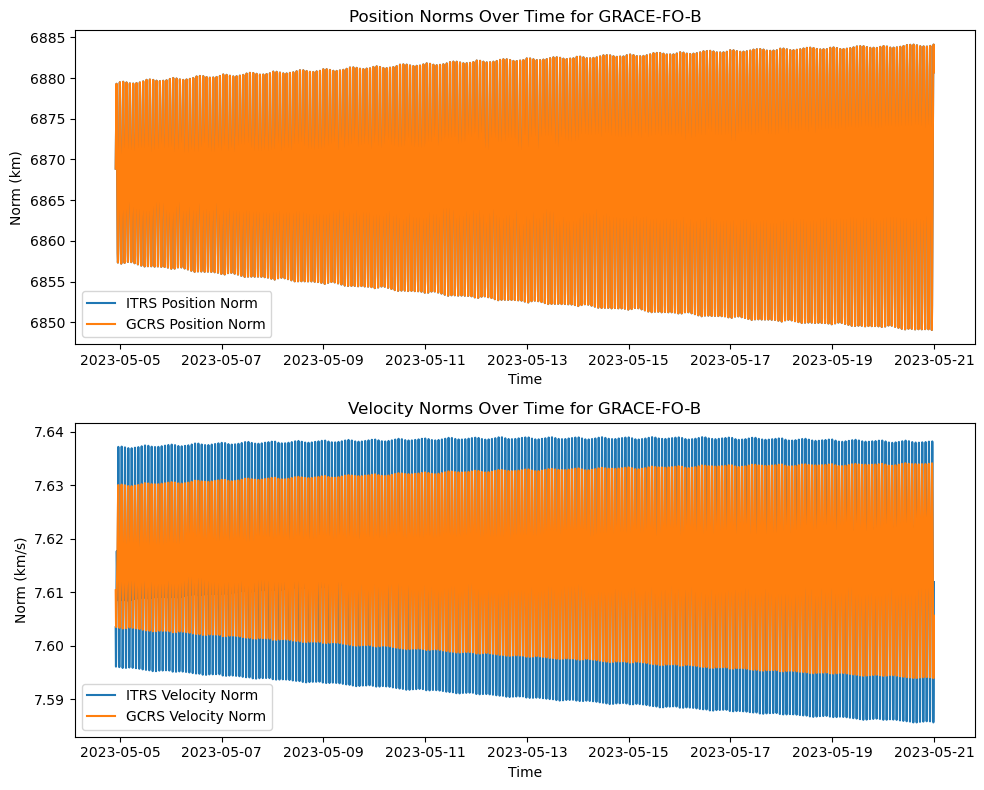

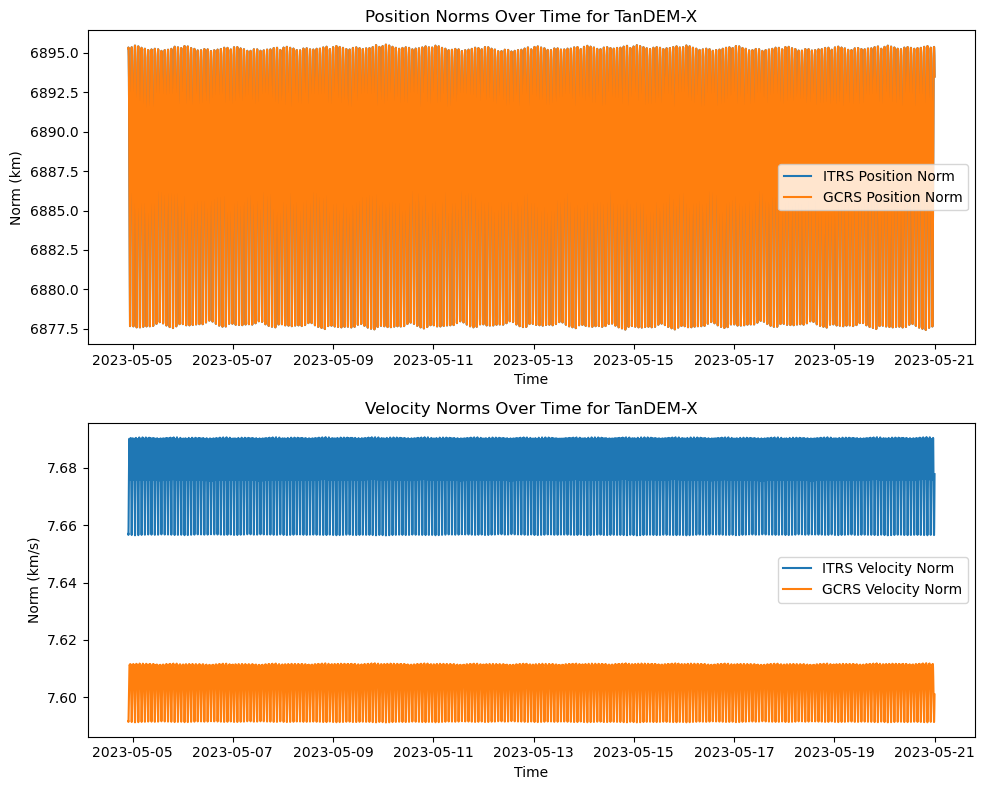

In [105]:
def plot_norms(df, satellite_name):
    # Calculate the norms for ITRS and GCRS (ECI) positions and velocities
    itrs_pos_norm = np.linalg.norm(df[['Position_X', 'Position_Y', 'Position_Z']].values, axis=1)
    itrs_vel_norm = np.linalg.norm(df[['Velocity_X', 'Velocity_Y', 'Velocity_Z']].values, axis=1)
    gcrs_pos_norm = np.linalg.norm(df[['pos_x_eci', 'pos_y_eci', 'pos_z_eci']].values, axis=1)
    gcrs_vel_norm = np.linalg.norm(df[['vel_x_eci', 'vel_y_eci', 'vel_z_eci']].values, axis=1)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(df.index, itrs_pos_norm, label='ITRS Position Norm')
    ax[0].plot(df.index, gcrs_pos_norm, label='GCRS Position Norm')
    ax[0].set_title(f'Position Norms Over Time for {satellite_name}')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Norm (km)')
    ax[0].legend()

    ax[1].plot(df.index, itrs_vel_norm, label='ITRS Velocity Norm')
    ax[1].plot(df.index, gcrs_vel_norm, label='GCRS Velocity Norm')
    ax[1].set_title(f'Velocity Norms Over Time for {satellite_name}')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Norm (km/s)')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Loop through each satellite DataFrame and plot
for satellite, df in concatenated_dfs.items():
    plot_norms(df, satellite)

In [108]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir

orekit.pyhelpers.download_orekit_data_curdir()
vm = orekit.initVM()
setup_orekit_curdir()

from org.orekit.frames import FramesFactory
from org.orekit.models.earth import ReferenceEllipsoid
from org.orekit.utils import IERSConventions, PVCoordinates
from orekit.pyhelpers import datetime_to_absolutedate
from org.hipparchus.geometry.euclidean.threed import Vector3D

xsp3 =  -6451.162034
ysp3 =   2345.375767 
zsp3 =    434.889956
vxsp3 = 5849.629125 
vysp3 =  1774.029407 
vzsp3 =  75927.078908

frame_CTS = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
frame_EME2000 = FramesFactory.getEME2000()

absolute_date = datetime_to_absolutedate(datetime.datetime(2023, 5, 4, 22, 0, 0))

cts_pos = Vector3D(float(xsp3), float(ysp3), float(zsp3))
cts_vel = Vector3D(float(vxsp3), float(vysp3), float(vzsp3))
pv_cts = PVCoordinates(cts_pos, cts_vel)

cts_to_eme2000 = frame_CTS.getTransformTo(frame_EME2000, absolute_date)
pveci = cts_to_eme2000.transformPVCoordinates(pv_cts)

print(pveci.getPosition())
print(pveci.getVelocity())

{6,802.5548468593; -925.5093689646; 419.628781917}
{-5,170.3200415574; -2,970.2443410337; 75,938.9782789598}
